In [258]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision.datasets import CelebA
from torchvision import transforms
import torchvision
from tqdm import tqdm
import torchvision.transforms.functional as TF
import math
from unet import SimpleUnet

In [259]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [260]:
# Transformations
transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1),
    ]
)

undo_transform = transforms.Compose(
    [
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: (t * 255.0).numpy().astype(np.uint8)),
    ]
)

In [261]:
class diffusion:
    def __init__(self, timesteps, scheduler_type=None):
        betas = torch.linspace(0.0001, 0.02, timesteps)

        alphas = 1 - betas
        sqrt_alphas = torch.sqrt(alphas)
        alpha_hats = torch.cumprod(1 - betas, axis=0)
        sqrt_alpha_hats = torch.sqrt(alpha_hats)

        sqrt_one_minus_alpha_hats = torch.sqrt(1 - alpha_hats)

        self.betas = betas
        self.alphas = alphas
        self.sqrt_alphas = sqrt_alphas
        self.alpha_hats = alpha_hats
        self.sqrt_alpha_hats = sqrt_alpha_hats
        self.sqrt_one_minus_alpha_hats = sqrt_one_minus_alpha_hats

    def noise_schedule(self, x_0, t, device="cpu"):
        noise = torch.randn(size=x_0.shape)

        alpha_hats_t = self.alpha_hats[t]
        alpha_hats_t = alpha_hats_t.reshape(shape=(t.shape[0], 1, 1, 1))

        sqrt_alpha_hats_t = self.sqrt_alpha_hats[t]
        sqrt_alpha_hats_t = sqrt_alpha_hats_t.reshape(shape=(t.shape[0], 1, 1, 1))

        sqrt_one_minus_alpha_hats_t = self.sqrt_one_minus_alpha_hats[t]
        sqrt_one_minus_alpha_hats_t = sqrt_one_minus_alpha_hats_t.reshape(
            shape=(t.shape[0], 1, 1, 1)
        )

        mean = sqrt_alpha_hats_t * x_0
        variance = sqrt_one_minus_alpha_hats_t * noise

        x_ts = mean + variance

        return x_ts.to(device), noise.to(device)

    @torch.no_grad()
    def sample(self, x_t, t, prediction):
        x_t = x_t.cpu()
        t = t.cpu()
        prediction = prediction.cpu()

        betas_t = self.betas[t]
        sqrt_alphas_t = self.sqrt_alphas[t]

        sqrt_one_minus_alpha_hats_t = self.sqrt_one_minus_alpha_hats[t]

        x_t_minus_one = (1 / sqrt_alphas_t) * (
            x_t - ((betas_t * prediction) / sqrt_one_minus_alpha_hats_t)
        )

        if t == 0:
            return x_t_minus_one
        else:
            noise = torch.randn_like(x_t)
            return x_t_minus_one + torch.sqrt(betas_t) * noise

In [262]:
image_data = torchvision.datasets.QMNIST("./data", download=True, transform=transform)
# data_loader = torch.utils.data.DataLoader(image_data, batch_size=16, shuffle=True)
# images, labels = next(iter(data_loader))

In [263]:
BATCH_SIZE = 256
NO_EPOCHS = 2
TIME_STEPS = 300

diffuser = diffusion(timesteps=TIME_STEPS)

In [264]:
# img = images[0]
# t = torch.tensor([100])
# noisy_image, _ = diffuser.noise_schedule(img, t=t, device=device)

# noisy_image = torch.clamp(noisy_image.cpu(), -1.0, 1.0)

# plt.imshow(undo_transform(noisy_image))

In [265]:
model = SimpleUnet(in_channels=1, out_channels=1)
model.to(device)

dataloader = torch.utils.data.DataLoader(
    image_data, batch_size=BATCH_SIZE, shuffle=True
)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(NO_EPOCHS):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, TIME_STEPS, (len(batch[0]),), device=device).long()

        img_batch_noisy, noise_batch = diffuser.noise_schedule(
            x_0=batch[0], t=t.cpu(), device=device
        )

        predicted_noise_batch = model(img_batch_noisy, t)

        loss = loss_fn(predicted_noise_batch, noise_batch)

        loss.backward()
        optimizer.step()

        if epoch % 5 == 0 and step % 50 == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            # sample_plot_image()

Epoch 0 | step 000 Loss: 1.2589514255523682 
Epoch 0 | step 050 Loss: 0.09347020834684372 
Epoch 0 | step 100 Loss: 0.06903177499771118 
Epoch 0 | step 150 Loss: 0.062384746968746185 
Epoch 0 | step 200 Loss: 0.05622456595301628 


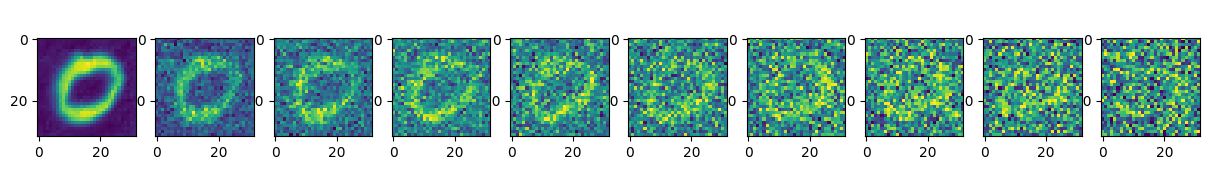

In [273]:
with torch.no_grad():
    img_size = 32
    img = torch.randn((3, 1, img_size, img_size))
    plt.figure(figsize=(15, 2))
    plt.axis("off")
    num_images = 10
    stepsize = int(TIME_STEPS / num_images)

    for i in range(0, TIME_STEPS)[::-1]:
        t = torch.full((1,), i, dtype=torch.long)

        img = img.to(device)
        t = t.to(device)

        prediction = model(img, t)

        img = diffuser.sample(img, t, prediction)

        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i / stepsize) + 1)
            plt.imshow(undo_transform(img.cpu()[0]))
    plt.show()